# Phishing Website Detection Notebook

This notebook demonstrates data loading, preprocessing, feature extraction, model training, and saving of models used in the Flask app.

What this notebook contains
- Load dataset from `dataset/phishing_site_urls.csv`.
- Tokenize and stem URL text, build a bag-of-words using `CountVectorizer`.
- Train simple classifiers (Logistic Regression and Multinomial Naive Bayes).
- Evaluate models and save serialized artifacts: `vectorizer.pkl`, `Phishing.pkl`, `phishing_mnb.pkl`.

Prerequisites
- Python 3.8+ and a virtual environment activated.
- Install dependencies:

```bash
pip install -r requirements.txt
pip install nltk wordcloud seaborn
```

Notes
- The notebook uses NLTK tokenizers and stemmers; you may need to download NLTK data (run `nltk.download('punkt')` if necessary).
- After running the training cells, the notebook saves pickled models in the notebook root. The Flask app expects `vectorizer.pkl` and `Phishing.pkl` (or a renamed `phishing_model.pkl`) in the project root.

Usage
1. Open this notebook in Jupyter or VS Code.
2. Run cells sequentially from top to bottom.
3. Verify the saved `.pkl` files exist before running the Flask app.

Warnings
- Pickle files can contain arbitrary code. Do not run or load pickles from untrusted sources.

---


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv('dataset/phishing_site_urls.csv')

In [3]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
df.shape

(549346, 2)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [6]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [7]:
 df.Label.value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

In [8]:
from nltk.tokenize import RegexpTokenizer

In [9]:
tokenizer=RegexpTokenizer(r'[A-Za-z]+')

In [10]:
df.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [11]:
tokenizer.tokenize(df.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [12]:
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))

In [13]:
df.head()

,URL,Label,text_tokenized
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


In [14]:
from nltk.stem.snowball import SnowballStemmer

In [15]:
stemmer=SnowballStemmer('english')

In [16]:
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

In [17]:
df.head()

,URL,Label,text_tokenized,text_stemmed
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide..."


In [18]:
df['text']= df['text_stemmed'].map(lambda l: ' '.join(l))

In [19]:
df.head()

,URL,Label,text_tokenized,text_stemmed,text
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [20]:
good_sites=df[df.Label=='good']
bad_sites=df[df.Label=='bad']

In [21]:
 good_sites.head()


,URL,Label,text_tokenized,text_stemmed,text
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [22]:
all_text=' '.join(good_sites['text'].tolist())

In [23]:
from wordcloud import WordCloud

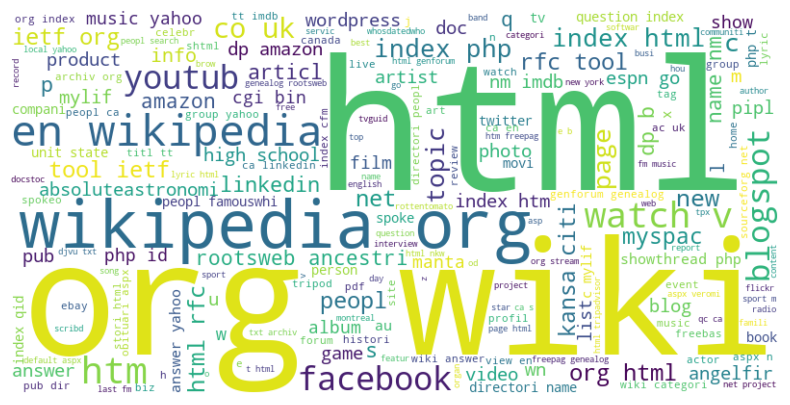

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
all_text = ' '.join(bad_sites['text'].tolist())

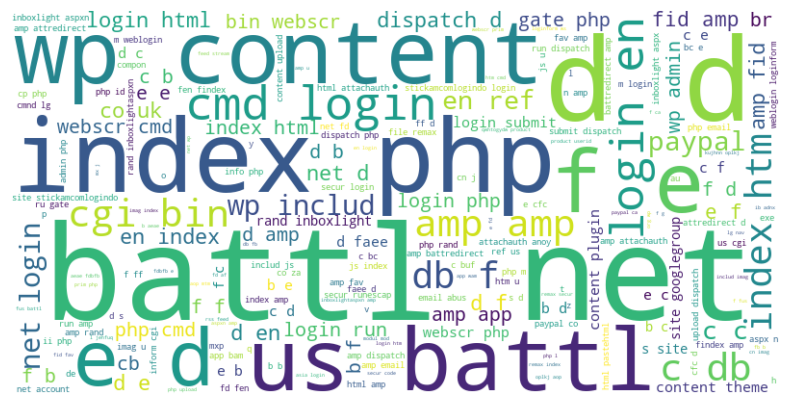

In [26]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
df.head()

,URL,Label,text_tokenized,text_stemmed,text
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
cv=CountVectorizer()

In [30]:
features=cv.fit_transform(df.text)

In [31]:
features[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(5, 350837))

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
 x_train, x_test, y_train, y_test = train_test_split(features, df.Label)

Model Training


In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
l_model = LogisticRegression()

In [69]:
l_model.fit(x_train,y_train)

C:\Users\Ruchir jaiswal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [70]:
l_model.score(x_test,y_test)

0.9648892869365139

In [71]:
l_model.score(x_train, y_train)

0.9788936649442124

In [59]:
from sklearn.metrics import classification_report

In [60]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(l_model.predict(x_test), y_test, target_names=['Bad','Good']))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36700
        Good       0.99      0.96      0.98    100637

    accuracy                           0.96    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.96      0.97    137337



In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
con_mat = pd.DataFrame(confusion_matrix(l_model.predict(x_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad','Actual:Good'])

In [63]:
import seaborn as sns

<Axes: >

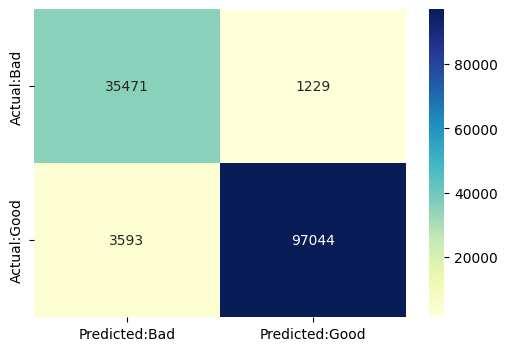

In [64]:
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap="YlGnBu")

In [65]:
from sklearn.naive_bayes import MultinomialNB

In [66]:
mnb=MultinomialNB()

In [47]:
mnb.fit(x_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [48]:
mnb.score(x_test, y_test)

0.9569598869933085

### save model


In [49]:
import pickle

In [50]:
pickle.dump(l_model, open('Phishing.pkl','wb'))

In [51]:
pickle.dump(mnb,open('phishing_mnb.pkl','wb'))

In [52]:
pickle.dump(cv, open('vectorizer.pkl','wb'))

#testing

In [53]:
URL=["yeniik.com./wp-admin/js/login.alibaba.com/login.jsp.php"]

In [54]:
predictURL=cv.transform(URL)

In [55]:
l_model.predict(predictURL)

array(['bad'], dtype=object)

In [68]:
import pickle

# Load vectorizer and model
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('Phishing.pkl', 'rb') as f:
    model = pickle.load(f)

# Test URL
url = ["http://example.com/login"]
x = vectorizer.transform(url)
print(model.predict(x))


['bad']
